# 0. Load parameters


In [15]:
# | tags: [parameters]
subject = "101"

In [35]:
# | tags: [parameters]
# Injected Parameters
subject = 101

In [41]:
import os
import mne
from pathlib import Path
from spectral.utils import print_date_time, read_parameters
from spectral.preproc import load_data, zapline_clean
from spectral.preproc import detrending, apply_pyprep, get_bad_channels
from spectral.viz import plot_step, plot_bad_channels


mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

print_date_time()
config = read_parameters()
project_path = config.get("paths", "PROJECT_PATH").strip("'").strip('"')

# Substitute the placeholders in the other paths
raw_preproc_path = config.get("paths", "RAW_PREPROC_PATH").format(
    project_path=project_path, subject=subject
)
figures_path = config.get("paths", "FIGURES_PATH").format(
    project_path=project_path, subject=subject
)
for var in [raw_preproc_path, figures_path]:
    # ar = var.format(project_path=project_path, subject=subject)

    Path(var).mkdir(parents=True, exist_ok=True)
    print(f"{var}")

2024-03-22 23:46:10
'/Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-101/'
'/Users/daniel/PhD/Projects/psd-path/analysis/figures/sub-101/'


This file contains preprocessing files after downsampling them.


# 1. Preprocess raw data


Loading data from /Users/daniel/PhD/Projects/psd-path/data/raw/BIDS/sub-101/ses-01/eeg/sub-101_ses-01_task-rest_eeg.set
Creating RawArray with float64 data, n_channels=258, n_times=300398
    Range : 0 ... 300397 =      0.000 ...   300.397 secs
Ready.
Detrending done
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s


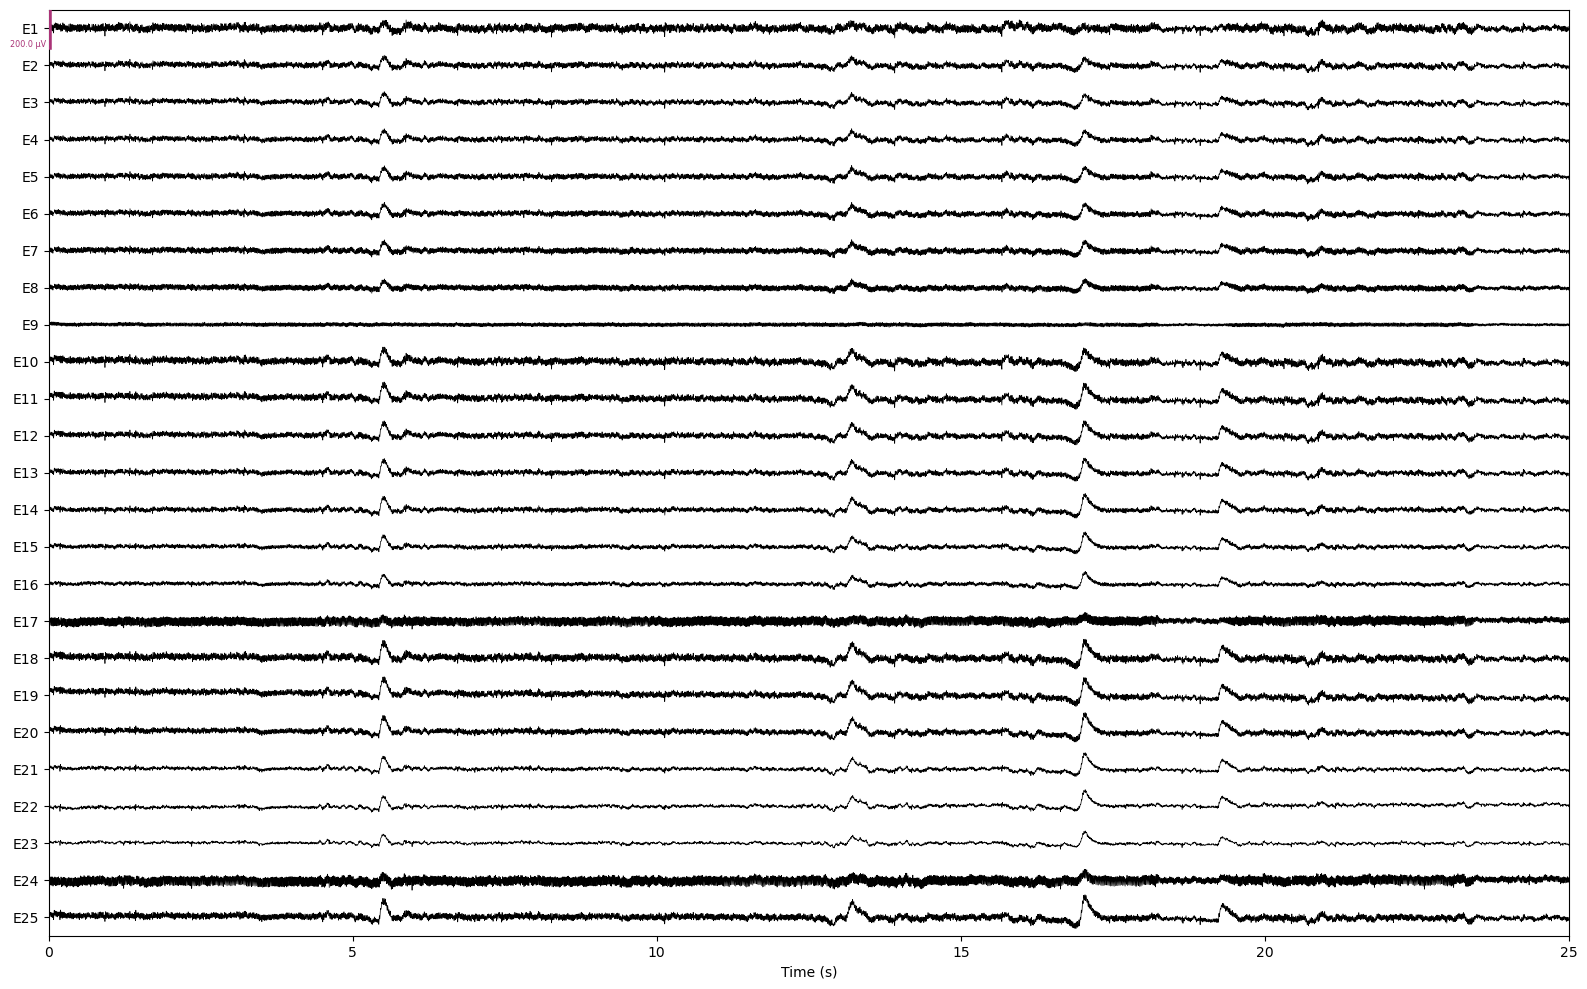

Effective window size : 4.096 (s)


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/spectral/viz.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,260 points
Good channels,"256 EEG, 1 ECG"
Bad channels,VREF
EOG channels,Not available
ECG channels,ECG
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


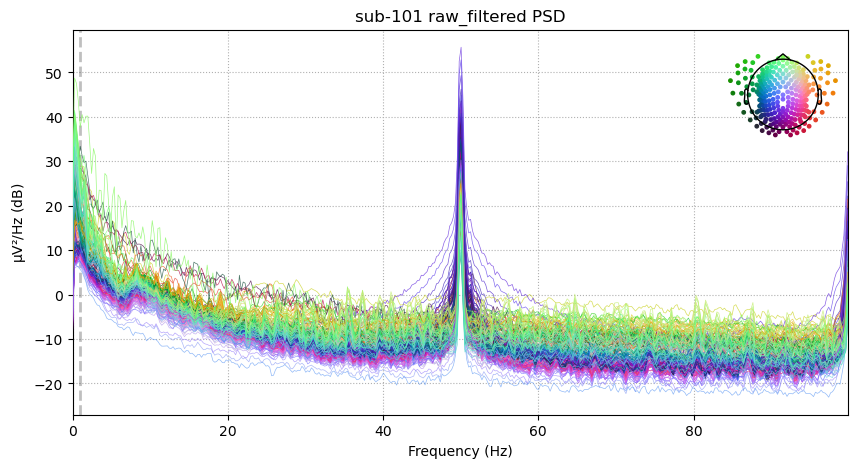

In [49]:
fline = 50
h_freq = 100
notch_freq = 50

filter_params = {
    "l_freq": 1,
    "h_freq": h_freq,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin2",
    "phase": "zero",
}


# .notch_filter(freqs=50)  # removedrifts
# print(project_path)
raw = load_data(subject, project_path=project_path)
raw.info["bads"] = ["VREF"]

raw_detrended = detrending(raw)
print("Detrending done")

raw_filtered = (
    raw_detrended.copy()
    .crop(tmin=5, tmax=300, include_tmax=True)
    .filter(**filter_params)
)

plot_step(
    raw_filtered,
    subject,
    figures_path,
    stage="raw_filtered",
    duration=25.0,
    n_channels=25,
    fmax=h_freq,
)

raw_filtered.info

Power of components removed by DSS: 0.23
Iteration 0 score: 8.918152737081901e-11
Power of components removed by DSS: 0.40
Iteration 1 score: 2.0323092114020833e-11
Power of components removed by DSS: 0.16
Iteration 2 score: 4.18994857433986e-12
Power of components removed by DSS: 0.02
Iteration 3 score: 2.1042903533144024e-12
Power of components removed by DSS: 0.02
Iteration 4 score: 8.140370607969836e-13
Power of components removed by DSS: 0.01
Iteration 5 score: 3.897217096888331e-13
Power of components removed by DSS: 0.00
Iteration 6 score: 3.58523777006964e-13
Power of components removed by DSS: 0.00
Iteration 7 score: 2.157626702782133e-13
Power of components removed by DSS: 0.00
Iteration 8 score: 1.3859029504920634e-13
Power of components removed by DSS: 0.00
Iteration 9 score: 1.1720412636595313e-13
Power of components removed by DSS: 0.00
Iteration 10 score: 9.075586296218339e-14
Power of components removed by DSS: 0.00
Iteration 11 score: 5.79647122958958e-14
Power of comp

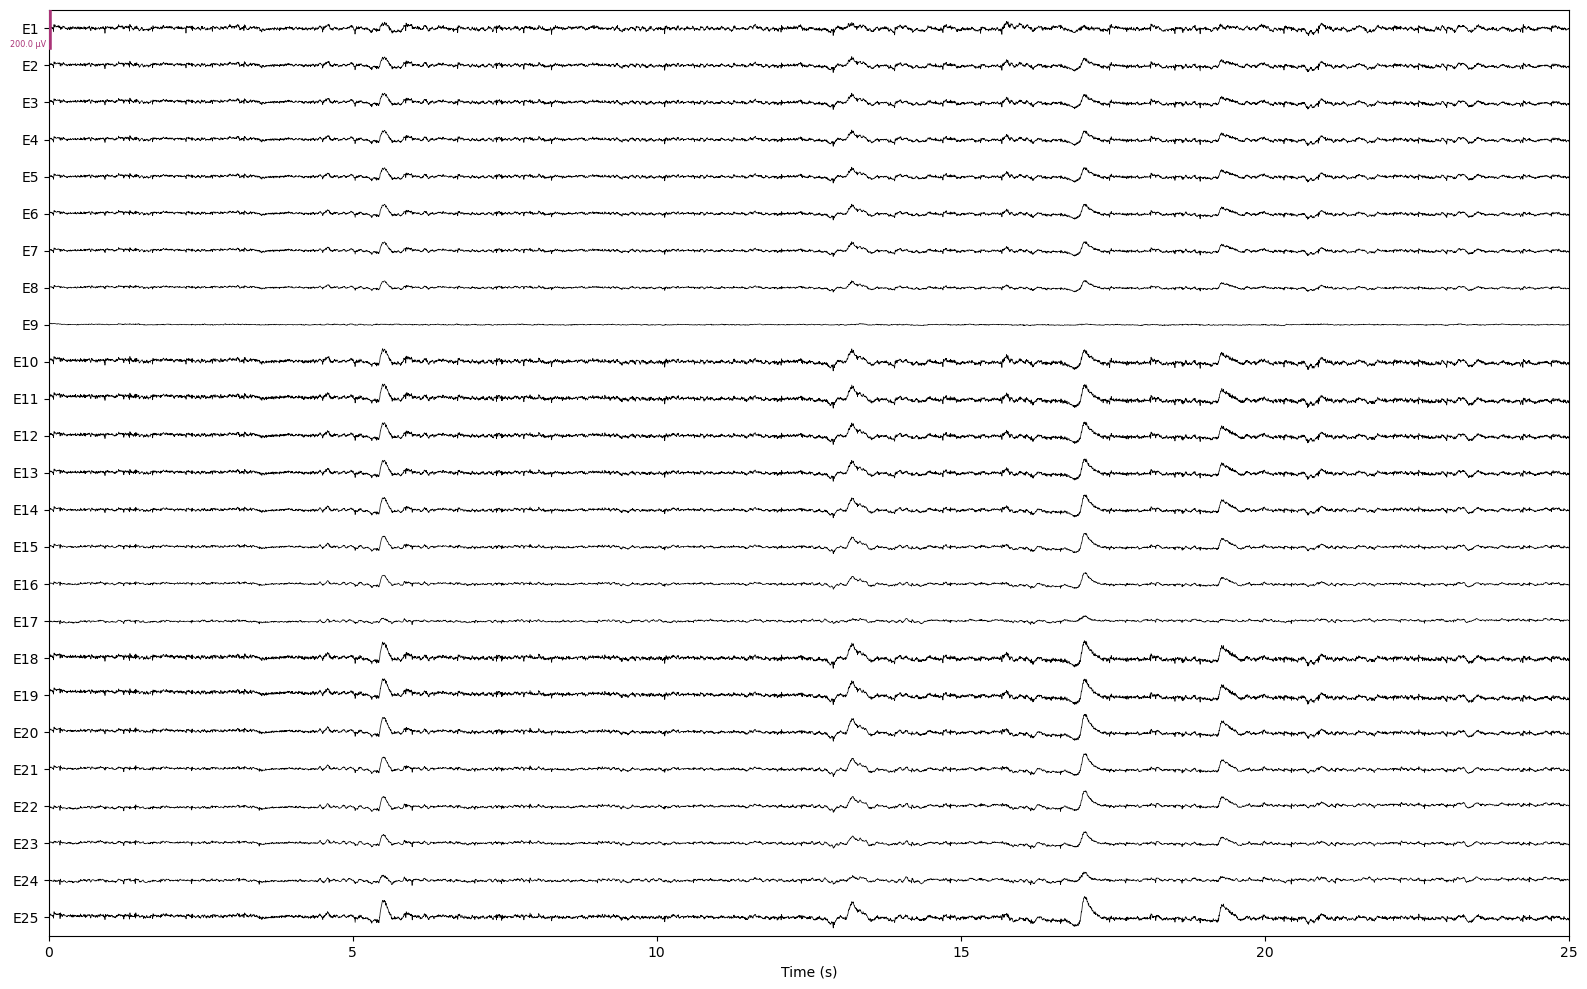

Effective window size : 4.096 (s)


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/spectral/viz.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


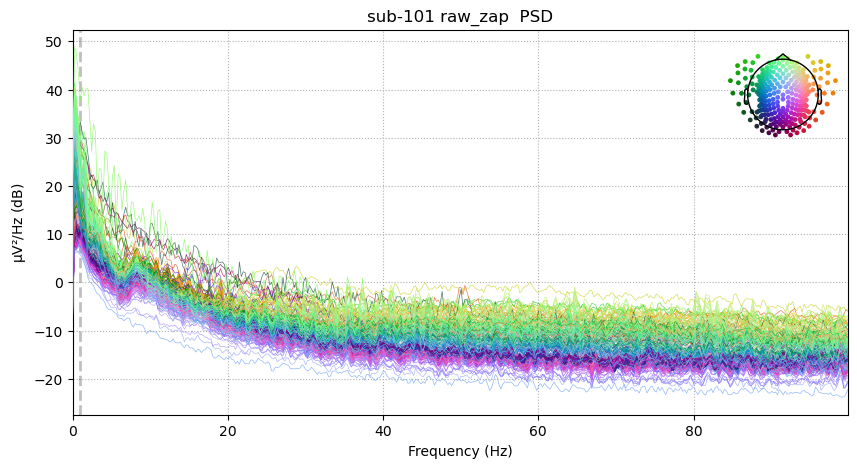

In [50]:
iter_param = {
    "nfft": 500,
    "n_iter_max": 200,
    "win_sz": 12.5,
    "spot_sz": 6,
}
raw_zap = zapline_clean(raw_filtered, fline, method="iter", iter_param=iter_param)

plot_step(
    raw_zap,
    subject,
    figures_path,
    stage="raw_zap ",
    duration=25.0,
    n_channels=25,
    fmax=h_freq,
)

In [45]:
pyprep = True

if pyprep:
    bad_channels_by_ransac = apply_pyprep(raw_zap)
else:
    bad_channels_by_ransac = get_bad_channels(raw_zap)

raw_zap.info["bads"].extend(bad_channels_by_ransac)
raw_zap.save(f"{raw_preproc_path}/sub-{subject}_filtered_zap_eeg.fif", overwrite=True)
raw_zap.info

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 246
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Found 11 uniquely bad channels:

0 by NaN: []

0 by flat: []

1 by deviation: ['E217']

2 by HF noise: ['E216', 'E238']

10 by correlation: ['E9', 'E132', 'E133', 'E145', 'E174', 'E216', 'E217', 'E229', 'E251', 'E256']

1 by SNR: ['E216']

0 by dropout: []

0 by RANSAC: []

bad all ['E133', 'E229', 'E9', 'E132', 'E145', 'E216', 'E217', 'E174', 'E256', 'E238', 'E251']
Overwriting existing file.
Writing /Users/daniel/PhD/Projects/psd-path/notebooks/1-preprocessing/'/Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-101/'/sub-101_filtered_zap_eeg.fif
Closing /Users/daniel/PhD/Projects/psd-path/notebooks/1-preprocessing/'/Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-101/'/sub-101_filtered_zap_eeg.fif
[done]


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,260 points
Good channels,"245 EEG, 1 ECG"
Bad channels,"VREF, E133, E229, E9, E132, E145, E216, E217, E174, E256, E238, E251"
EOG channels,Not available
ECG channels,ECG
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


In [1]:
_ = plot_bad_channels(raw_zap, subject, figures_path=figures_path)

NameError: name 'plot_bad_channels' is not defined

In [48]:
print(
    f"{subject} -  identified {len(raw_zap.info['bads'])
                               }  bad channels: {raw_zap.info['bads']}"
)
print_date_time()

101 -  identified 12  bad channels: ['VREF', 'E133', 'E229', 'E9', 'E132', 'E145', 'E216', 'E217', 'E174', 'E256', 'E238', 'E251']
2024-03-23 00:05:45
